In [1]:
#Import Necessary libraries
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
from torchvision import transforms
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from tqdm import tqdm

In [2]:
#will use drakbackground style for plotting (images are also with black bg)
# plt.style.use("dark_background")

In [3]:
PATH = "/kaggle/input/paddy-segment/data"

In [4]:
df = pd.read_csv(f"{PATH}/data.csv")
df.head()

,id,img_file,class,masks
0,1,brown_spot39.jpg,brown_spot,1-brown_spot.png
1,2,brown_spot38.jpg,brown_spot,2-brown_spot.png
2,3,brown_spot37.jpg,brown_spot,3-brown_spot.png
3,4,brown_spot36.jpg,brown_spot,4-brown_spot.png
4,5,brown_spot35.jpg,brown_spot,5-brown_spot.png


In [5]:
def random_samples():
    """Function to vizualize random sample of MRI image and corresponding mask"""
    idx = np.random.randint(0, len(df)-1, (2))
    plt.figure(figsize=(5,5))

    for i in range(2):
        row = df.iloc[idx[i]]
        plt.subplot(2,2,i*2+1)
        img = Image.open(f'{PATH}/imgs/{row["img_file"]}')
        plt.imshow(img)
        plt.title(f"Image:{row['class']}")
        plt.axis("off")


        plt.subplot(2,2,i*2+2)
        if row["class"]=="normal":
            mask = np.zeros(img.size)
        else:
            mask = Image.open(f'{PATH}/masks/{row["masks"]}')
        plt.imshow(mask,cmap="gray")
        plt.title("Mask")
        plt.axis("off")

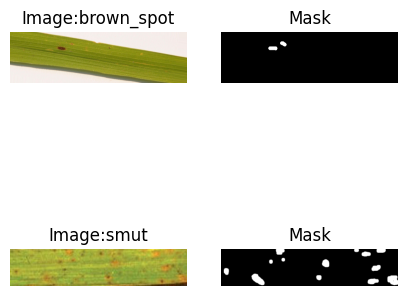

In [6]:
random_samples()

In [7]:
class RandomHFlip():
    """Performs random horizontal flip with given probaility"""
    def __init__(self,p=0.5):
        self.prob = p

    def __call__(self, pair):
        img,mask = pair
        if torch.rand((1,)).item() > self.prob:
            img,mask = TF.hflip(img), TF.hflip(mask)

        return img,mask

In [8]:
class RandomAffine():
    """Performs random affine transformation(rotate, translate, scaling and shear) with given probaility"""
    def __init__(self, degrees=None, translate=None, scale_ranges=None, shears=None):
        self.params = {
                'degrees': degrees,
                'translate': translate,
                'scale_ranges': scale_ranges,
                'shears': shears
        }

    def __call__(self, pair):
        img, mask = pair
        w, h = img.size

        #get parameters for random affine transformations
        angle, translations, scale, shear = transforms.RandomAffine.get_params(self.params['degrees'], self.params['translate'], self.params['scale_ranges'], self.params['shears'], (w,h))

        # apply TF.affine using fixed parameters
        img = TF.affine(img, angle, translations, scale, shear)
        mask = TF.affine(mask, angle, translations, scale, shear)
        return img, mask

In [9]:
class ToTensorPair():
    """Convert PIL image to tensor, also does normalization"""
    def __call__(self,pair):
        img,mask = pair
        img,mask = transforms.ToTensor()(img), transforms.ToTensor()(mask)

        return img,mask

In [10]:
class ResizePair():
    """Convert PIL image to tensor, also does normalization"""
    def __call__(self,pair):
        img,mask = pair
        img,mask = transforms.Resize((256,256))(img), transforms.Resize((256,256))(mask)

        return img,mask

In [11]:
transform = transforms.Compose([
    RandomHFlip(),
    RandomAffine((-10,10),(0.1,0.1),(1,1.3),(-7,7)),
    ResizePair(),
    ToTensorPair()

])

In [12]:
class MyDataset(Dataset):
    """Custom dataset to load image pask pair"""
    def __init__(self,df,transform):
        self.images = df["img_file"]
        self.masks = df["masks"]
        self.dis = df["class"]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        image = Image.open(f"{PATH}/imgs/{self.images[idx]}")
        if self.dis[idx]=="normal":
            mask = Image.fromarray(np.zeros(image.size))
        else:
            mask = Image.open(f"{PATH}/masks/{self.masks[idx]}")

        image,mask = self.transform((image, mask))
#         mask = self.transform(mask)
        return image[:3],mask


In [13]:
dataset = MyDataset(df,transform)

In [14]:
def show_sample(pair):
    img,mask = pair
    plt.subplot(1,2,1)
    plt.imshow(img.permute(1,2,0))
    plt.axis("off")    

    plt.subplot(1,2,2)
    plt.imshow(mask.permute(1,2,0),cmap="gray")
    plt.axis("off")

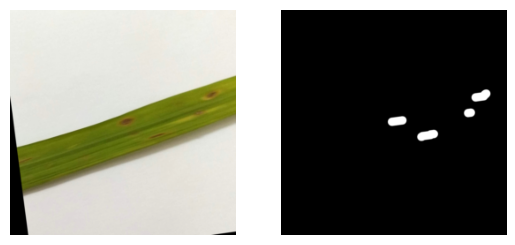

In [15]:
i = torch.randint(1,len(dataset),(1,)).item()
show_sample(dataset[i])

In [16]:
#split dataset into train and validation set
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [17]:
BATCH_SIZE = 32

In [18]:
train_loader =  DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader =  DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [19]:
class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(DoubleConv, self).__init__()

        self.dconv =  nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
      )

    def forward(self,x):
        return self.dconv(x)


class Down(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Down, self).__init__()

        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            DoubleConv(in_channels,out_channels)
      )

    def forward(self,x):
        return self.down(x)


class Up(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Up, self).__init__()

        self.up = nn.ConvTranspose2d(in_channels,out_channels, kernel_size=(2, 2), stride=(2, 2))
        self.dconv = DoubleConv(in_channels,out_channels)


    def forward(self,x,skip):
        x = self.up(x)
        x = torch.cat((x,skip), dim=1)
        return self.dconv(x)

In [20]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = DoubleConv(3,32)
        self.enc2 = Down(32,64)
        self.enc3 = Down(64, 128)
        self.enc4 = Down(128, 256)

        self.bn =  Down(256,512)

        self.dec4 = Up(512, 256)
        self.dec3 = Up(256, 128)
        self.dec2 = Up(128, 64)
        self.dec1 = Up(64,32)

        self.conv = nn.Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))

    def forward(self,x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        bottle = self.bn(enc4)

        dec4 = self.dec4(bottle,enc4)
        dec3 = self.dec3(dec4,enc3)
        dec2 = self.dec2(dec3,enc2)
        dec1 = self.dec1(dec2,enc1)

        op = self.conv(dec1)


        return op

In [21]:
model = UNet()

In [22]:
def train(model,EPOCHS,train_loader,val_loader, criterion,lr = 0.001,):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_n = len(train_loader)

    optimizer = Adam(model.parameters(), lr=lr)
    model = model.to(device)

    train_loss = []
    val_loss = [0]

    for epoch in range(EPOCHS):
        model.train(True)
        pbar = tqdm(train_loader)

        batch_loss = []

        for i,data in enumerate(pbar):
            inputs,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(inputs)
            # Compute the loss and its gradients
            loss = criterion(outputs, labels)
            loss.backward()

            batch_loss.append(loss.item())
            # Adjust learning weights
            optimizer.step()

            pbar.set_description(f"Epoch: {epoch + 1}/{EPOCHS}; Train Loss: {round(np.mean(batch_loss),3)};\
            Val Loss: {round(val_loss[-1],3)};")

          # Set the model to evaluation mode, disabling dropout and using population
          # statistics for batch normalization.
        model.eval()
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            val_batch_loss = []
            for i, vdata in enumerate(val_loader):
                vinputs, vlabels = vdata
                vinputs = vinputs.to(device)
                vlabels = vlabels.to(device)
                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels).item()

                val_batch_loss.append(vloss)

        val_loss.append(np.mean(val_batch_loss))
        train_loss.append(np.mean(batch_loss))

    return train_loss,val_loss

In [23]:
EPOCHS = 500

In [24]:
model = UNet()

In [25]:
train_loss,val_loss  = train(model,EPOCHS,train_loader,val_loader,BCEWithLogitsLoss(),lr=3e-5)

Epoch: 1/500; Train Loss: 0.921;            Val Loss: 0;: 100%|██████████| 6/6 [00:19<00:00,  3.29s/it]
Epoch: 2/500; Train Loss: 0.888;            Val Loss: 0.707;: 100%|██████████| 6/6 [00:15<00:00,  2.64s/it]
Epoch: 3/500; Train Loss: 0.862;            Val Loss: 0.726;: 100%|██████████| 6/6 [00:16<00:00,  2.69s/it]
Epoch: 4/500; Train Loss: 0.84;            Val Loss: 0.741;: 100%|██████████| 6/6 [00:15<00:00,  2.66s/it]
Epoch: 5/500; Train Loss: 0.816;            Val Loss: 0.75;: 100%|██████████| 6/6 [00:15<00:00,  2.58s/it]
Epoch: 6/500; Train Loss: 0.796;            Val Loss: 0.748;: 100%|██████████| 6/6 [00:15<00:00,  2.61s/it]
Epoch: 7/500; Train Loss: 0.774;            Val Loss: 0.741;: 100%|██████████| 6/6 [00:15<00:00,  2.61s/it]
Epoch: 8/500; Train Loss: 0.761;            Val Loss: 0.735;: 100%|██████████| 6/6 [00:15<00:00,  2.62s/it]
Epoch: 9/500; Train Loss: 0.742;            Val Loss: 0.725;: 100%|██████████| 6/6 [00:15<00:00,  2.55s/it]
Epoch: 10/500; Train Loss: 0.728; 

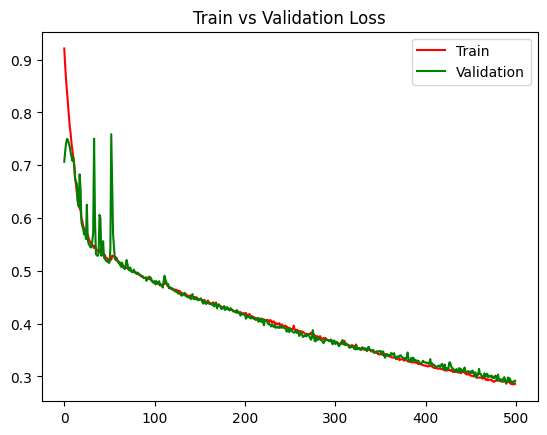

In [26]:
plt.plot(list(range(EPOCHS)),train_loss,c="red")
plt.plot(list(range(EPOCHS)),val_loss[1:],c="green")
plt.legend(["Train","Validation"])
plt.title("Train vs Validation Loss")
plt.show()

In [27]:
torch.save(model.state_dict(), "unet_1.pth")

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
model = model.to(device)

In [30]:
def random_pred(thresh=0.7):
    with torch.no_grad():
        samp = val_dataset[torch.randint(1,40,(1,))[0].item()]
        img = samp[0].to(device)
        mask = samp[1]
        op = model(img.unsqueeze(0)).cpu().squeeze(0)
        op = torch.sigmoid(op)
        op = (op>thresh).int()

        plt.subplot(1,3,1)
        plt.imshow(img.cpu().permute(1,2,0),cmap="gray")
        plt.title("MRI Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(mask.permute(1,2,0),cmap="gray")
        plt.title("Original Mask")

        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(op.permute(1,2,0),cmap="gray")
        plt.title("Predicted mask")
        plt.axis("off")

        plt.show()

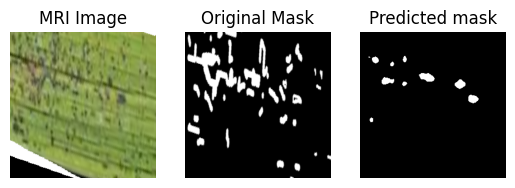

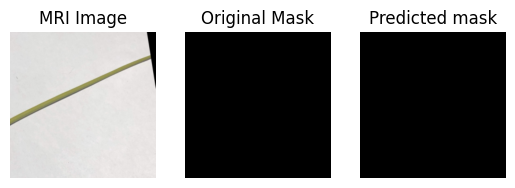

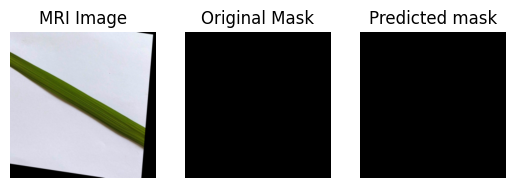

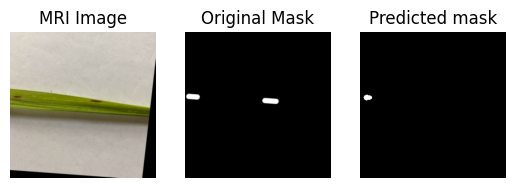

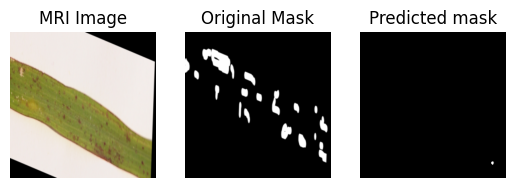

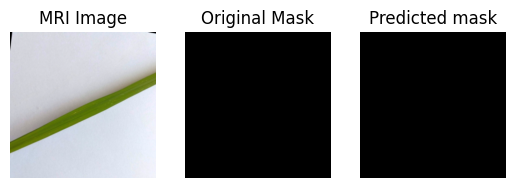

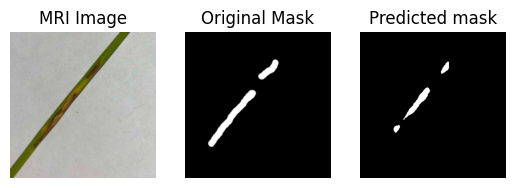

In [31]:
for i in range(7):
    random_pred()

In [32]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
        self.bce = BCEWithLogitsLoss()

    def forward(self, inputs, targets, smooth=1):
        bce = self.bce(inputs, targets)
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = 1- ((2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth))

        return bce + dice

In [33]:
model2 = UNet()

In [34]:
train_loss2,val_loss2  = train(model2,EPOCHS,train_loader,val_loader,DiceLoss(),lr=3e-5)

Epoch: 1/500; Train Loss: 1.575;            Val Loss: 0;: 100%|██████████| 6/6 [00:15<00:00,  2.65s/it]
Epoch: 2/500; Train Loss: 1.547;            Val Loss: 1.61;: 100%|██████████| 6/6 [00:15<00:00,  2.65s/it]
Epoch: 3/500; Train Loss: 1.532;            Val Loss: 1.6;: 100%|██████████| 6/6 [00:15<00:00,  2.63s/it]
Epoch: 4/500; Train Loss: 1.505;            Val Loss: 1.589;: 100%|██████████| 6/6 [00:15<00:00,  2.63s/it]
Epoch: 5/500; Train Loss: 1.496;            Val Loss: 1.566;: 100%|██████████| 6/6 [00:16<00:00,  2.72s/it]
Epoch: 6/500; Train Loss: 1.48;            Val Loss: 1.539;: 100%|██████████| 6/6 [00:16<00:00,  2.73s/it]
Epoch: 7/500; Train Loss: 1.46;            Val Loss: 1.505;: 100%|██████████| 6/6 [00:16<00:00,  2.72s/it]
Epoch: 8/500; Train Loss: 1.435;            Val Loss: 1.485;: 100%|██████████| 6/6 [00:15<00:00,  2.65s/it]
Epoch: 9/500; Train Loss: 1.424;            Val Loss: 1.452;: 100%|██████████| 6/6 [00:16<00:00,  2.70s/it]
Epoch: 10/500; Train Loss: 1.399;    

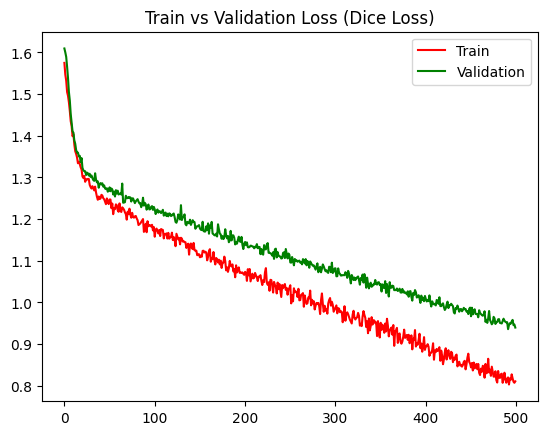

In [35]:
plt.plot(list(range(EPOCHS)),train_loss2,c="red")
plt.plot(list(range(EPOCHS)),val_loss2[1:],c="green")
plt.legend(["Train","Validation"])
plt.title("Train vs Validation Loss (Dice Loss)")
plt.show()

In [36]:
torch.save(model2.state_dict(), "unet_2.pth")

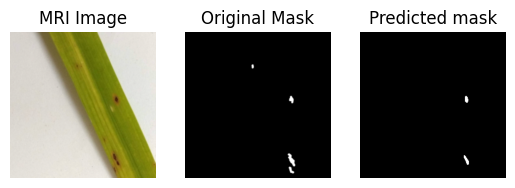

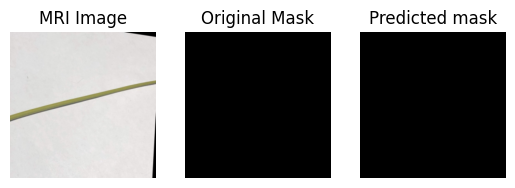

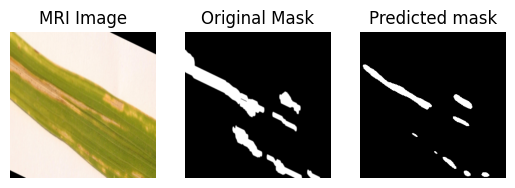

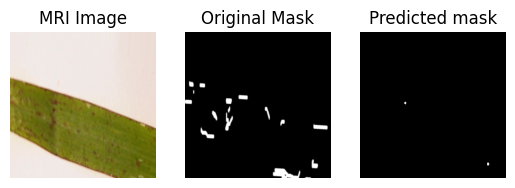

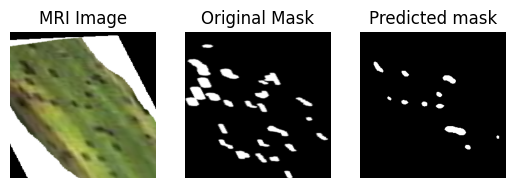

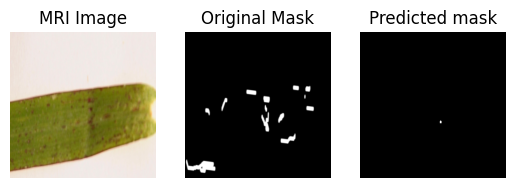

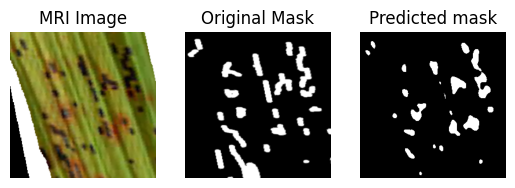

In [37]:
for i in range(7):
    random_pred(0.9)

In [38]:
#Happy learning